In [1]:
import numpy as np
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 25 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

(3, 600)


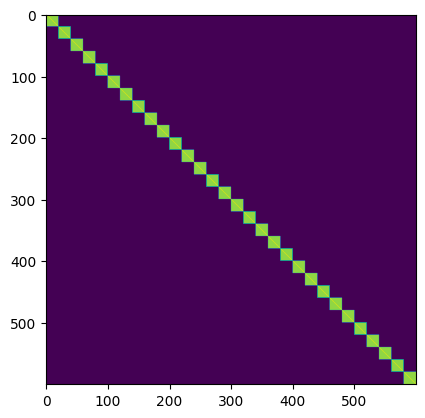

In [5]:
# Syllables and time stamps
# syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
N_shared_channels = 20
syl_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
plt.imshow(syl_cov)
syl = rng.multivariate_normal(np.ones(NE), syl_cov, size=N_syl)
print(syl.shape)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)

In [6]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

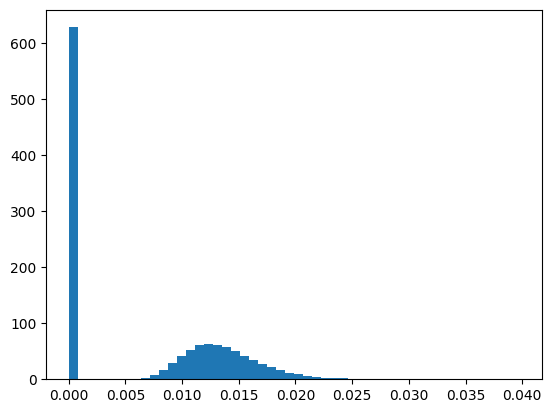

In [8]:
gen = lognormal_gen
# gen = const_gen
c = 0.5
JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.2, 0.6]) / 3
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
# c = 1
# JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.25, 0.9])
# sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=c<=0.5) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=c<=0.5) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=c<=0.5) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=c<=0.5) / np.sqrt(NI)
if issparse(JEE):
    plt.hist(JEE.toarray().flatten(), bins=50, density=True)
else:
    plt.hist(JEE.flatten(), bins=50, density=True)

In [9]:
rEmax, rImax, thE, thI, sE, sI = 40, 100, -5, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [10]:
r_rest = 1 # target rate when phi(0)
rmax, s = 40, 2
th = -erfinv(r_rest * 2 / rmax - 1) * (np.sqrt(2) * s)
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [11]:
def bilin_hebb(net, aiv, hvc, lr, w0_mean, tauW):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * (aiv - 1) * h - (net.W[:,i] - w0_mean)
        net.W[:,i] = np.clip(net.W[:,i] + dW / tauW, a_min=0, a_max=None)

In [12]:
w0_mean = 1/N_HVC
w_inh, wI = w0_mean, 0.0
tauE, tauI, dt = 40, 10, 1

netFF = WCNet(NE, N_HVC, w0_mean, phi, tauE, w_inh=w_inh)
netEI = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
              JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
              w_inh=w_inh, wI=wI, w0_std=1e-3)

Not a recurrent model and rI will not be calculated.


100%|███████████████████████████████████████| 999/999 [00:00<00:00, 3588.48it/s]


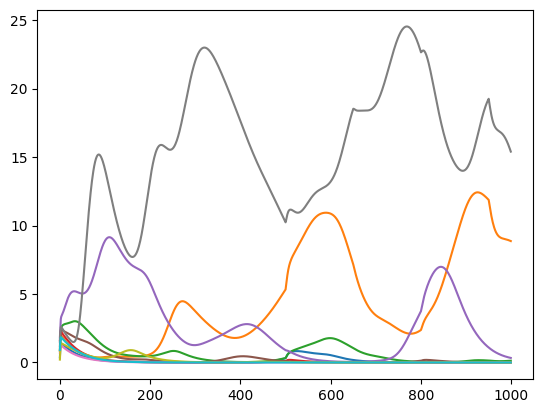

In [13]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
aux = [np.zeros_like(rH[:1000])+rH[:1000].mean(axis=1)[:,None], 
       np.zeros_like(aud[:1000])+aud[:1000].mean(axis=1)[:,None]]
_ = netEI.sim(rE0, rI0, *aux, [], 1000, dt, 0)
rE, rI, _, _, hE = _
plt.plot(rE[:1000,:10]);

In [14]:
def bilin_hebb(net, aiv, hvc, lr, w0_mean, tauW):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * (aiv - 1) * h - (net.W[:,i] - w0_mean)
        net.W[:,i] = np.clip(net.W[:,i] + dW / tauW, a_min=0, a_max=None)

In [15]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
_ = netEI.sim(rE0, rI0, rH, aud, [], T, dt, 1, bilin_hebb,
              lr=-8e-2, w0_mean=w0_mean, tauW=1e5)
_ = netFF.sim(rE0, rH, aud, [], T, dt, 1, bilin_hebb,
              lr=-5e-2, w0_mean=w0_mean, tauW=1e5)

100%|███████████████████████████████████| 15499/15499 [00:03<00:00, 4149.84it/s]


## Test Model with Different Scenarios

In [16]:
Experiment.AUD_LIST

('correct', 'shuf_syl_idx', 'perturb', 'off')

In [17]:
expEI = Experiment(netEI, rH, syl, noise=1, T_test=T_burn+T_rend, 
                   t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
expFF = Experiment(netFF, rH, syl, noise=1, T_test=T_burn+T_rend, 
                   t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
pert_mean = np.ones(NE)
pert_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
pert = rng.multivariate_normal(pert_mean, pert_cov, size=syl.shape[0])
pert_args = [(pert, 0)]
test_codes = ('correct', 'perturb', 'off', 'correct') # last one for playback
if_sing = (True, True, True, False)
test_names = ('Singing\ncorrect', 'Singing\nperturb',
              'Singing\ndeafen', 'Playback\n')
EI_tests_all = expEI.sim_multi(test_codes, if_sing, pert_args * len(test_codes))
FF_tests_all = expFF.sim_multi(test_codes, if_sing, pert_args * len(test_codes))

100%|████████████████████████████████████| 1099/1099 [00:00<00:00, 20151.96it/s]


In [18]:
len(FF_tests_all['rE'])

4

0 600
424 176
90 60


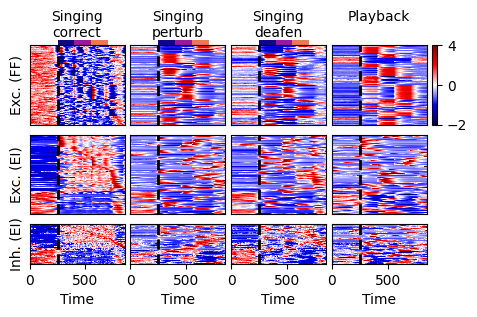

In [19]:
ti, tj = T_burn//2, T_burn + T_rend #int(tsyl_end[2,0])
pop = ('Exc. (FF)', 'Exc. (EI)', 'Inh. (EI)')
fig, ax = plt.subplots(len(pop), len(test_names)+1, 
                       figsize=(1.15*len(test_names), 3), 
                       width_ratios=[1]*len(test_names)+[0.05], 
                       height_ratios=[1, 1, 0.5])
for p in range(len(pop)):
    zs = []
    tests = FF_tests_all if p == 0 else EI_tests_all
    for k, l in enumerate(tests['r'+pop[p][0]]):
        zs.append(normalize(l[ti:tj], axis=0))

    zmin = max(min(list(map(lambda _: _[0].min(), zs))), -2)
    zmax = min(max(list(map(lambda _: _[0].max(), zs))), 4)
    idx = temporal_sort(zs[0], 'dmean', t0=T_burn-ti)[1]

    norm = TwoSlopeNorm(0, -2, 4)
    
    for k, (z, l) in enumerate(zip(zs, test_names)):
        # Uncomment the below to sort case-by-case
        # idx = temporal_sort(z, t0=T_burn-i)[1]
        im = ax[p,k].imshow(z[:,idx].T, aspect='auto', cmap='seismic', 
                            interpolation='none', norm=norm, rasterized=True)
        if p == 0:
            cbar = fig.colorbar(im, cax=ax[p,-1])
            # cbar.set_ticks([np.ceil(zmin), 0, np.floor(zmax)-1])
            cbar.set_ticks([-2, 0, 4])
        else:
            ax[p,-1].set_axis_off()
        ax[p,k].axvline(T_burn-ti, ls='--', c='k', lw=2)
        ax[0,k].set(xticks=[], yticks=[])
        ax[1,k].set(xticks=[],yticks=[])
        ax[0,k].set_title(l, fontsize=10)
        ax[-1,k].set(xlabel='Time', yticks=[])
    N = zs[0].shape[1]
    ax[p,0].set(ylabel=pop[p], yticks=[])#, yticks=[N//2, N])

cmap = plt.get_cmap('plasma')
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
for k in range(3):
    for i, (t0, t1) in enumerate(ts):
        ax[0,k].add_patch(plt.Rectangle((t0, 0), t1-t0, -N/4, fc=cmap(i/N_syl), 
                                         clip_on=False, linewidth=0))
fig.tight_layout(pad=0.1)
fig.savefig('svg/raster_EI_FF.svg')

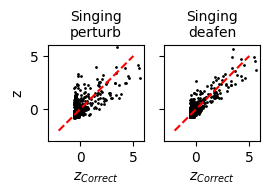

In [20]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_ctrl_vs_nonctrl(EI_tests_all['rE'][:-1], test_names[:-1], ti, tj)
fig.savefig('svg/joint_dist_c_vs_nc_EI.svg')

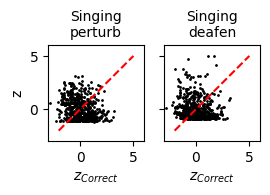

In [21]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_ctrl_vs_nonctrl(FF_tests_all['rE'][:-1], test_names[:-1], ti, tj)
fig.savefig('svg/joint_dist_c_vs_nc_FF.svg')

In [40]:
from itertools import product
shuff_expEI = Experiment(netEI, rH, syl, noise=1, T_test=T_burn+T_rend, 
                         t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
shuff_expFF = Experiment(netFF, rH, syl, noise=1, T_test=T_burn+T_rend, 
                         t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
shuff_idxs = [np.array(i) for i in product(range(3), repeat=3) 
              if (i[0] != i[1]) and (i[0] != i[2]) and (i[1] != i[2])]
pert_mean = np.ones(NE)
pert_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
pert_args = [(pert_mean, pert_cov, 0)]
test_codes = ['shuf_syl_idx'] * len(shuff_idxs)
if_sing = [False] * len(shuff_idxs)
test_names = ['Playback\n' + str(i) for i in shuff_idxs]
EI_tests_shuff = shuff_expEI.sim_multi(test_codes, if_sing, shuff_idx_list=shuff_idxs)
FF_tests_shuff = shuff_expFF.sim_multi(test_codes, if_sing, shuff_idx_list=shuff_idxs)

100%|████████████████████████████████████| 1099/1099 [00:00<00:00, 23181.11it/s]


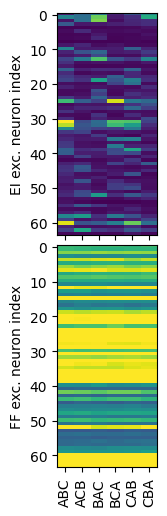

In [74]:
mean_rE_shuff_EI = np.vstack([i.mean(axis=0) for i in EI_tests_shuff['rE']])
mean_rE_shuff_FF = np.vstack([i.mean(axis=0) for i in FF_tests_shuff['rE']])
mask_EI = mean_rE_shuff_EI.std(axis=0) / mean_rE_shuff_EI.mean(axis=0) > 0.5
mask_FF = mean_rE_shuff_FF.std(axis=0) / mean_rE_shuff_FF.mean(axis=0) > 0.5

im_EI = mean_rE_shuff_EI[:,mask_EI]
im_FF = np.zeros_like(mean_rE_shuff_EI[:,mask_EI])

im_FF[:,:int(np.sum(mask_FF))] = mean_rE_shuff_FF[:,mask_FF]
im_FF[:,int(np.sum(mask_FF)):] = mean_rE_shuff_FF[:,~mask_FF][:,:im_FF.shape[1]-int(np.sum(mask_FF))]

vmax = im_EI.max() #max(im_EI.max(), im_FF.max())
fig, ax = plt.subplots(2, figsize=(1.5, 5), sharex='all', sharey='all')
ax[0].imshow(im_EI.T, aspect='auto', vmin=0, vmax=vmax, interpolation='none', rasterized=True)
ax[1].imshow(im_FF.T, aspect='auto', vmin=0, vmax=vmax, interpolation='none', rasterized=True)
ax[0].set(ylabel='EI exc. neuron index', xlabel='\n\n')
ax[1].set(ylabel='FF exc. neuron index')
shuff_chars = [''.join(i) for i in product(('A', 'B', 'C'), repeat=3) 
              if (i[0] != i[1]) and (i[0] != i[2]) and (i[1] != i[2])]
ax[0].set_xticks(np.arange(len(shuff_chars)), labels=shuff_chars, rotation=90)
ax[1].set_xticks(np.arange(len(shuff_chars)), labels=shuff_chars, rotation=90)
fig.tight_layout(pad=0.1)
fig.savefig('svg/playback_seq_selectivity.svg')